<a href="https://colab.research.google.com/github/POPE001/dubme_task/blob/main/dubme_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Processing for STT Enhancement

This notebook presents a solution for enhancing Speech-to-Text (STT) accuracy by separating vocals from background noise in a video file. The approach includes audio extraction, separation using Spleeter, noise reduction, and transcription with accuracy evaluation using WER.

##  Overview:
1. **Extract Audio from Video**: Using FFmpeg to extract the audio track from the video.
2. **Separate Audio Components**: Applying Spleeter for vocal and background noise separation.
3. **Noise Reduction**: Implementing noise reduction techniques on the vocal track.
4. **Transcription and Evaluation**: Transcribing audio using Google Speech Recognition and evaluating with Word Error Rate (WER).
5. **Integration and Scalability Discussion**: Considering how this solution fits into a larger STT pipeline.


In [ ]:
# Installations (if necessary, move to setup section )
!pip install spleeter noisereduce soundfile SpeechRecognition pydub matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import noisereduce as nr
import librosa
import soundfile as sf
import numpy as np
import subprocess
from pydub import AudioSegment
import speech_recognition as sr
from IPython.display import Audio
from IPython.display import Video
import librosa
from scipy.fft import rfft, irfft
from spleeter.separator import Separator


# Setting Up and Mounting Drive
This section mounts the Google Drive to access the video file for processing.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_to_video = '/content/drive/My Drive/adream.mp4'
Video(path_to_video)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Base Project Path Setup
# -----------------------
# This script uses a specific folder in Google Drive to store all output files.
# The base path below points to a folder named 'AudioProcessing' in Google Drive.
# Please ensure that you create this folder in your Google Drive before running the script.
# All the outputs, including extracted audios, cleaned vocals, and background noises,
# will be saved in this folder. This approach helps in keeping the project organized and
# makes it easier to locate and manage the output files.
#
# To create the folder, go to your Google Drive, create a new folder named 'AudioProcessing',
# and note down its path. If you choose a different folder name or location, update the base path accordingly.
base_project_path = "/content/drive/My Drive/AudioProcessing"

# Ensure that the base_project_path is correctly set to the folder you created in Google Drive.
# The script will save all output files in this directory.


# Audio Extraction from Video
Extract the audio track from the video file using ffmpeg. This audio will be used for further processing.


In [ ]:

def extract_audio(video_file, output_audio_file):
    """
    Extracts the audio from a video file using ffmpeg.

    Args:
    video_file (str): The path to the video file.
    output_audio_file (str): The path where the extracted audio will be saved.

    Returns:
    bool: True if extraction is successful, False otherwise.
    """
    try:
        command = [
            "ffmpeg",
            "-i", video_file,
            "-ab", "160k",
            "-ac", "2",
            "-ar", "44100",
            "-vn", output_audio_file
        ]
        subprocess.run(command, check=True)
        return True
    except subprocess.CalledProcessError as e:
        print(f"An error occurred during audio extraction: {e}")
        return False

# Define file paths
video_file = path_to_video
audio_file = os.path.join(base_project_path, "output_audio.wav")

# Extract audio from video
if extract_audio(video_file, audio_file):
    print("Audio extracted and saved to:", audio_file)
else:
    print("Audio extraction failed.")

# Check if the audio file exists
if os.path.exists(audio_file):
    print("Audio file found at the specified path.")
else:
    print("Audio file not found, please check the path.")


Audio extracted and saved to: /content/drive/My Drive/AudioProcessing/output_audio.wav
Audio file found at the specified path.


## Separating Vocals and Background Noise with Spleeter

Spleeter is used here to separate the vocals and background noise from the extracted audio file.


In [ ]:
def separate_audio(input_file, output_directory):
    """
    Separates the audio into vocals and background using Spleeter.

    Args:
    input_file (str): Path to the input audio file.
    output_directory (str): Directory where the separated audio tracks will be saved.
    """
    # Create the output directory if it does not exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Initialize the Spleeter separator with the 2stems model
    separator = Separator('spleeter:2stems')

    # Perform the separation
    separator.separate_to_file(input_file, output_directory)

# Path for the audio file to separate
audio_file = os.path.join(base_project_path, "output_audio.wav")

# Directory where the separated audio will be saved
output_directory = os.path.join(base_project_path, "SeparatedAudio")

# Separate the audio file into vocals and background
separate_audio(audio_file, output_directory)

print(f"Audio separation completed. Files saved in {output_directory}")

INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Validating archive checksum


INFO:spleeter:Validating archive checksum


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:2stems model file(s) extracted


INFO:spleeter:2stems model file(s) extracted
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
Colocations handled automatically by placer.


INFO:spleeter:File /content/drive/My Drive/AudioProcessing/SeparatedAudio/output_audio/vocals.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/AudioProcessing/SeparatedAudio/output_audio/vocals.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/AudioProcessing/SeparatedAudio/output_audio/accompaniment.wav written succesfully


INFO:spleeter:File /content/drive/My Drive/AudioProcessing/SeparatedAudio/output_audio/accompaniment.wav written succesfully


Audio separation completed. Files saved in /content/drive/My Drive/AudioProcessing/SeparatedAudio


## Noise Reduction on Vocal Track

Two noise reduction techniques are used here: standard noise reduction and spectral gating.


In [ ]:
def reduce_noise(input_file, output_directory, output_filename, noise_reduction_level=0.3, preserve_duration=3):
    """
    Reduces noise from an audio file, preserving the initial part of the audio.

    Args:
    input_file (str): Path to the input audio file.
    output_directory (str): Directory where the processed audio file will be saved.
    output_filename (str): Name of the output file.
    noise_reduction_level (float): Level of noise reduction.
    preserve_duration (int): Duration in seconds of the initial part of the audio to preserve.

    Returns:
    str: Path to the processed audio file, or None if an error occurs.
    """
    try:
        # Load the audio file
        y, sr = librosa.load(input_file, sr=None)

        # Extracting the portions to preserve and to apply noise reduction
        preserved_initial_audio = y[:preserve_duration * sr]  # Initial audio to preserve
        rest_audio = y[preserve_duration * sr:]  # Remaining audio for noise reduction

        # Apply noise reduction
        reduced_rest_audio = nr.reduce_noise(y=rest_audio, sr=sr, prop_decrease=noise_reduction_level)

        # Concatenating the preserved and noise-reduced audio
        reduced_noise_audio = np.concatenate((preserved_initial_audio, reduced_rest_audio))

        # Preparing the output path
        output_path = os.path.join(output_directory, output_filename)

        # Saving the processed audio
        sf.write(output_path, reduced_noise_audio, sr)
        return output_path
    except Exception as e:
        print(f"Error during noise reduction: {e}")
        return None

# Define the base project path and specific file paths
input_vocals_path = os.path.join(base_project_path, "SeparatedAudio/output_audio/vocals.wav")
output_directory = base_project_path

# Perform noise reduction and save the output
cleaned_vocals_path = reduce_noise(input_vocals_path, output_directory, "cleaned_vocals.wav")

# Verifying and providing feedback on the process
if cleaned_vocals_path:
    print(f"Cleaned vocals saved at: {cleaned_vocals_path}")
else:
    print("Noise reduction failed.")

Cleaned vocals saved at: /content/drive/My Drive/AudioProcessing/cleaned_vocals.wav


In [ ]:
# Define the paths for the audio files (cleaned and original)
cleaned_vocals_path = "/content/drive/My Drive/AudioProcessing/cleaned_vocals.wav"
original_audio_path = "/content/drive/My Drive/AudioProcessing/output_audio.wav"


##Function to Plot Waveform

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def plot_waveform(file_path, title="Audio Waveform"):
    """
    Plots the waveform of an audio file.

    Args:
    file_path (str): Path to the audio file.
    title (str): Title of the plot.
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()


##Visualizing Waveform

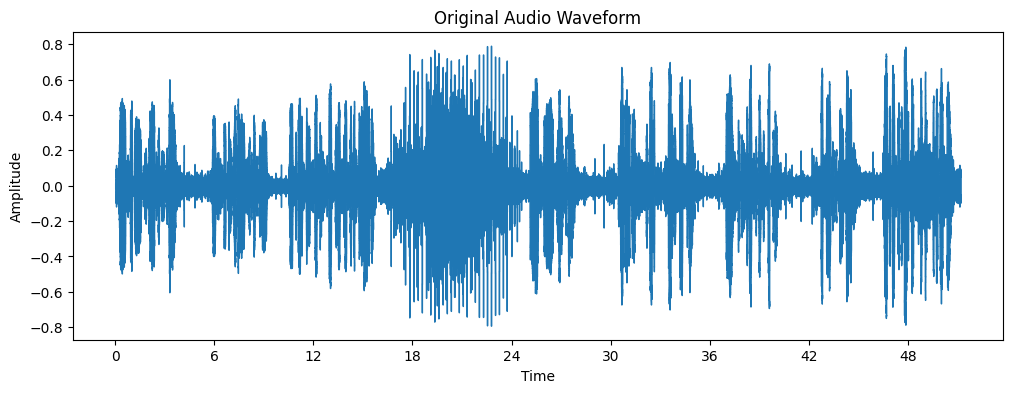

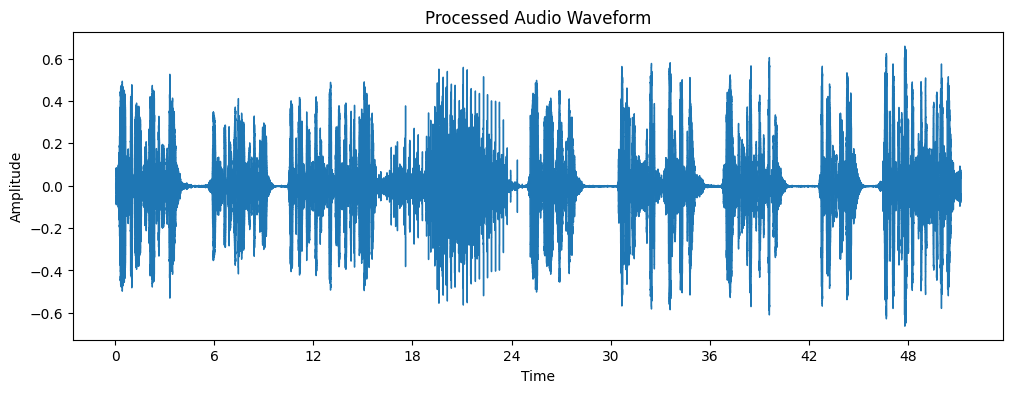

In [ ]:
# Paths to the original and processed audio files
original_audio_path = original_audio_path
processed_audio_path = cleaned_vocals_path

# Plotting the original audio
plot_waveform(original_audio_path, title="Original Audio Waveform")

# Plotting the processed (noise-reduced) audio
plot_waveform(processed_audio_path, title="Processed Audio Waveform")


#Visualizing Spectrogram

In [ ]:
def plot_spectrogram(file_path, title="Audio Spectrogram"):
    """
    Plots the spectrogram of an audio file.

    Args:
    file_path (str): Path to the audio file.
    title (str): Title of the plot.
    """
    y, sr = librosa.load(file_path, sr=None)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


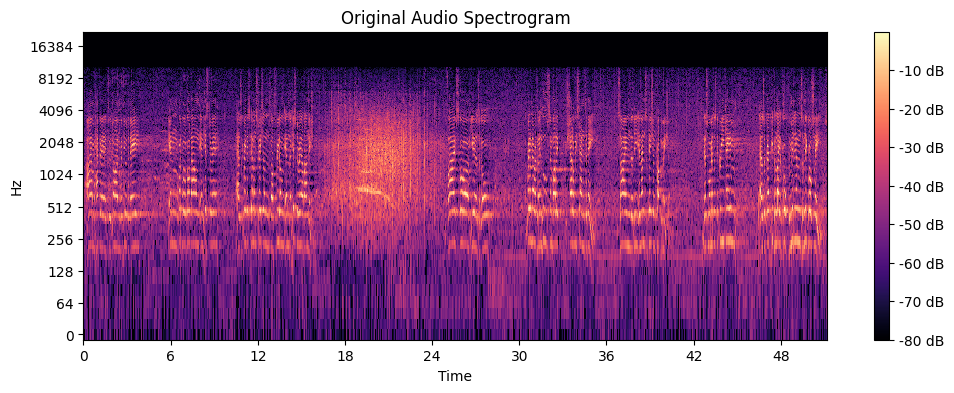

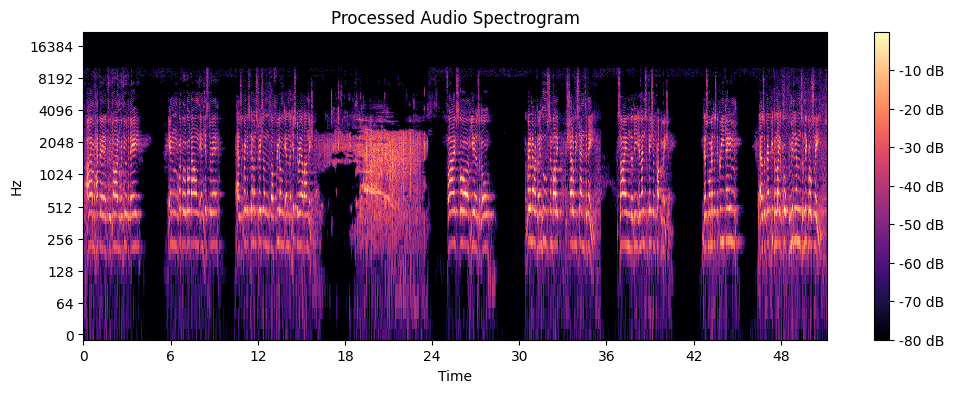

In [ ]:
# Plotting the original audio spectrogram
plot_spectrogram(original_audio_path, title="Original Audio Spectrogram")

# Plotting the processed audio spectrogram
plot_spectrogram(processed_audio_path, title="Processed Audio Spectrogram")


In [ ]:
def list_files_in_directory(directory_path):
    """
    Lists the files in a specified directory.

    Args:
    directory_path (str): Path to the directory.

    Returns:
    None
    """
    if os.path.exists(directory_path):
        files = os.listdir(directory_path)
        if files:
            print("Files in the output directory:")
            for file in files:
                print(f"- {file}")
        else:
            print("The output directory is empty.")
    else:
        print(f"Output directory not found at: {directory_path}")

# Define the path to the output directory
output_directory_path = "/content/drive/My Drive/AudioProcessing/SeparatedAudio/output_audio"

# List files in the output directory
list_files_in_directory(output_directory_path)


Files in the output directory:
- vocals.wav
- accompaniment.wav


In [ ]:

def play_audio(file_path):
    """
    Plays an audio file within the notebook.

    Args:
    file_path (str): Path to the audio file.
    """
    if os.path.exists(file_path):
        display(Audio(filename=file_path))
    else:
        print(f"Audio file not found at: {file_path}")

# Play the cleaned vocals
print("Playing cleaned vocals:")
play_audio(cleaned_vocals_path)


In [ ]:
# Define the path to the accompaniment file
accompaniment_path = f"{output_directory_path}/accompaniment.wav"

# Play the accompaniment
print("Playing accompaniment:")
play_audio(accompaniment_path)


## Transcribing the Audio and Evaluating with WER

Transcribe the cleaned and original audio tracks and compute the Word Error Rate (WER) to evaluate the transcription accuracy.


In [ ]:
def calculate_wer(reference, hypothesis):
    """
    Calculates the Word Error Rate (WER) between a reference text and a hypothesis text.

    Args:
    reference (str): The reference text.
    hypothesis (str): The hypothesis text (transcription).

    Returns:
    float: The WER value.
    """
    ref = reference.split()
    hyp = hypothesis.split()
    d = np.zeros((len(ref) + 1) * (len(hyp) + 1), dtype=np.uint8)
    d = d.reshape((len(ref) + 1, len(hyp) + 1))

    for i in range(len(ref) + 1):
        for j in range(len(hyp) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i
            else:
                substitution_cost = 0 if ref[i - 1] == hyp[j - 1] else 1
                d[i][j] = min(d[i - 1][j] + 1, d[i][j - 1] + 1, d[i - 1][j - 1] + substitution_cost)

    return d[-1][-1] / float(len(ref))

def split_audio(file_path, start_ms, chunk_length_ms=30000):
    """
    Splits the audio file into a chunk.

    Args:
    file_path (str): Path to the audio file.
    start_ms (int): Start time of the chunk in milliseconds.
    chunk_length_ms (int): Length of the chunk in milliseconds.

    Returns:
    AudioSegment: The audio chunk.
    """
    audio = AudioSegment.from_wav(file_path)
    end_ms = start_ms + chunk_length_ms
    return audio[start_ms:min(end_ms, len(audio))]

def transcribe_chunk(chunk, recognizer):
    """
    Transcribes a chunk of audio.

    Args:
    chunk (AudioSegment): The audio chunk.
    recognizer (Recognizer): Speech recognition recognizer.

    Returns:
    str: Transcribed text.
    """
    try:
        with chunk.export(format="wav") as exported_chunk:
            with sr.AudioFile(exported_chunk) as source:
                audio_data = recognizer.record(source)
                return recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        return "[Inaudible]"
    except sr.RequestError as e:
        return f"[Error: {e}]"

def transcribe_audio(file_path, start_ms=0):
    """
    Transcribes an audio file from a specified start time.

    Args:
    file_path (str): Path to the audio file.
    start_ms (int): Start time for transcription in milliseconds.

    Returns:
    str: Transcribed text.
    """
    recognizer = sr.Recognizer()
    chunk = split_audio(file_path, start_ms)
    return transcribe_chunk(chunk, recognizer)
# Reference text for both segments
reference_text_first_30s = ("I am happy to join with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation"
                            "Five score years ago")
reference_text_second_30s = ("a great American in whose symbolic shadow we stand today signed the deal Emancipation Proclamation"
                             "This momentous decree came as a great beacon light of hope to millions of Negro slaves")

# Transcriptions
cleaned_vocals_first_30s = transcribe_audio(cleaned_vocals_path)
cleaned_vocals_second_30s = transcribe_audio(cleaned_vocals_path, 30000)

original_vocals_first_30s = transcribe_audio(original_audio_path)
original_vocals_second_30s = transcribe_audio(original_audio_path, 30000)

# Calculate WER
wer_cleaned_first = calculate_wer(reference_text_first_30s, cleaned_vocals_first_30s)
wer_cleaned_second = calculate_wer(reference_text_second_30s, cleaned_vocals_second_30s)

wer_original_first = calculate_wer(reference_text_first_30s, original_vocals_first_30s)
wer_original_second = calculate_wer(reference_text_second_30s, original_vocals_second_30s)

# Print results
print("Cleaned Vocals (First 30s):", cleaned_vocals_first_30s)
print("WER (Cleaned Vocals - First 30s):", wer_cleaned_first)
print("Cleaned Vocals (Second 30s):", cleaned_vocals_second_30s)
print("WER (Cleaned Vocals - Second 30s):", wer_cleaned_second)

print("Original Audio (First 30s):", original_vocals_first_30s)
print("WER (Original Audio - First 30s):", wer_original_first)
print("Original Audio (Second 30s):", original_vocals_second_30s)
print("WER (Original Audio - Second 30s):", wer_original_second)


Cleaned Vocals (First 30s): I am happy to John with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation
WER (Cleaned Vocals - First 30s): 0.16666666666666666
Cleaned Vocals (Second 30s): a great American in whose symbolic Shadow We Stand today signed the Emancipation Proclamation this momentous decree came as a great Beacon Light Of Hope to millions of negro slaves
WER (Cleaned Vocals - Second 30s): 0.36666666666666664
Original Audio (First 30s): I am happy to John with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation five score years ago
WER (Original Audio - First 30s): 0.1
Original Audio (Second 30s): a great American in whose symbolic Shadow We Stand today signed the Emancipation Proclamation this momentous decree came as a great Beacon Light Of Hope to millions of negro slaves
WER (Original Audio - Second 30s): 0.36666666666666664
